# APIM ❤️ OpenAI

## Model routing lab
![flow](../../images/model-routing.gif)

Playground to try routing to a backend based on Azure OpenAI model and version.

### TOC
- [0️⃣ Initialize notebook variables](#0)
- [1️⃣ Create the Azure Resource Group](#1)
- [2️⃣ Create deployment using 🦾 Bicep](#2)
- [3️⃣ Get the deployment outputs](#3)
- [🧪 Test the API using a direct HTTP call](#requests)
- [🧪 Test the API using the Azure OpenAI Python SDK](#sdk)
- [🗑️ Clean up resources](#clean)

### Backlog
- Improve the notebook

### Prerequisites
- [Python 3.12 or later version](https://www.python.org/) installed
- [Pandas Library](https://pandas.pydata.org/) installed
- [VS Code](https://code.visualstudio.com/) installed with the [Jupyter notebook extension](https://marketplace.visualstudio.com/items?itemName=ms-toolsai.jupyter) enabled
- [Azure CLI](https://learn.microsoft.com/cli/azure/install-azure-cli) installed
- [An Azure Subscription](https://azure.microsoft.com/free/) with Contributor permissions
- [Access granted to Azure OpenAI](https://aka.ms/oai/access)
- [Sign in to Azure with Azure CLI](https://learn.microsoft.com/cli/azure/authenticate-azure-cli-interactively)

<a id='0'></a>
### 0️⃣ Initialize notebook variables

- Resources will be suffixed by a unique string based on your subscription id.
- Adjust the location parameters according your preferences and on the [product availability by Azure region.](https://azure.microsoft.com/explore/global-infrastructure/products-by-region/?cdn=disable&products=cognitive-services,api-management) 
- Adjust the OpenAI model and version according the [availability by region.](https://learn.microsoft.com/azure/ai-services/openai/concepts/models) 

In [10]:
import os
import json
import datetime
import requests

deployment_name = os.path.basename(os.path.dirname(globals()['__vsc_ipynb_file__']))
index = ''  # Set a matching value here and in clean-up-resources.ipynb if you want separate instances of the lab. This is helpful when tearing down resources and mitigating API Management's soft delete.
resource_group_name = f"lab-{deployment_name}{index}" # change the name to match your naming style
resource_group_location = "westeurope"

# Define three OpenAI model and version combinations
# https://learn.microsoft.com/azure/ai-services/openai/concepts/models#gpt-35
# Please note that availability of models and versions is variable and that you may need to adjust the model and version names to match the available models and versions in your Azure subscription.
# For this lab, we are using the following combinations based on PayGo availability on June 21, 2024:
#
#   1) GPT-3.5 Turbo 1106: France Central, Sweden Central
#   2) GPT-3.5 Turbo 0125: North Central US, South Central US
#   3) GPT-4o 2024-05-13: East US, West US

openai_model_gpt_35_turbo_0125 = { "name": "gpt-35-turbo", "version": "0125" }
openai_model_gpt_35_turbo_1106 = { "name": "gpt-35-turbo", "version": "1106" }
openai_model_gpt_4o_20240513 = { "name": "gpt-4o", "version": "2024-05-13" }

openai_model_1_name = "gpt-35-turbo"
openai_model_1_version = "11065675"
#openai_model_1_name = "gpt-4o"
#openai_model_1_version = "2024-05-13"
openai_deployment_1_name = f"{openai_model_1_name}-{openai_model_1_version}"
openai_resources_1 = [ {"name": "oai-francecentral", "location": "francecentral"}, {"name": "oai-swedencentral", "location": "swedencentral"} ]

openai_model_2_name = "gpt-35-turbo"
openai_model_2_version = "0125"
openai_deployment_2_name = f"{openai_model_2_name}-{openai_model_2_version}"
openai_resources_2 = [ {"name": "oai-northcentralus", "location": "northcentralus"}, {"name": "oai-southcentralus", "location": "southcentralus"} ]

openai_model_3_name = "gpt-4o"
openai_model_3_version = "2024-05-13"
openai_deployment_3_name = f"{openai_model_3_name}-{openai_model_3_version}"
openai_resources_3 = [ {"name": "oai-eastus", "location": "eastus"}, {"name": "oai-westus", "location": "westus"} ]

# Define Azure OpenAI resources
openai_resources_sku = "S0"
openai_api_version = "2024-02-01"
openai_specification_url='https://raw.githubusercontent.com/Azure/azure-rest-api-specs/main/specification/cognitiveservices/data-plane/AzureOpenAI/inference/stable/' + openai_api_version + '/inference.json'

# Define Azure API Management
apim_resource_name = "apim"
apim_resource_location = "westeurope"
apim_resource_sku = "Basicv2"

# Define the Azure OpenAI backends and backend pools per Azure OpenAI model and version
openai_backend_pool_1 = f"oai-backend-pool-{openai_deployment_1_name}"
openai_backend_pool_2 = f"oai-backend-pool-{openai_deployment_2_name}"
openai_backend_pool_3 = f"oai-backend-pool-{openai_deployment_3_name}"

log_analytics_name = "workspace"
app_insights_name = 'insights'


<a id='1'></a>
### 1️⃣ Create the Azure Resource Group
All resources deployed in this lab will be created in the specified resource group. Skip this step if you want to use an existing resource group.

In [3]:
# type: ignore
resource_group_stdout = ! az group create --name {resource_group_name} --location {resource_group_location}

if resource_group_stdout.n.startswith("ERROR"):
    print(resource_group_stdout)
else:
    print("✅ Azure Resource Group ", resource_group_name, " created ⌚ ", datetime.datetime.now().time())

✅ Azure Resource Group  lab-model-routing  created ⌚  16:22:53.488517


<a id='2'></a>
### 2️⃣ Create deployment using 🦾 Bicep

This lab uses [Bicep](https://learn.microsoft.com/azure/azure-resource-manager/bicep/overview?tabs=bicep) to declarative define all the resources that will be deployed. Change the parameters or the [main.bicep](main.bicep) directly to try different configurations. 

In [2]:
if len(openai_resources_1) > 0:
    backend_id_1 = openai_backend_pool_1 if len(openai_resources_1) > 1 else openai_resources_1[0].get("name")
if len(openai_resources_2) > 0:
    backend_id_2 = openai_backend_pool_2 if len(openai_resources_2) > 1 else openai_resources_2[0].get("name")
if len(openai_resources_3) > 0:
    backend_id_3 = openai_backend_pool_3 if len(openai_resources_3) > 1 else openai_resources_3[0].get("name")

with open("policy.xml", 'r') as policy_xml_file:
    policy_template_xml = policy_xml_file.read()
    policy_xml = policy_template_xml.replace("{backend-id-1}", backend_id_1).replace("{backend-id-2}", backend_id_2).replace("{backend-id-3}", backend_id_3)
    policy_xml_file.close()
open("policy.xml", 'w').write(policy_xml)

bicep_parameters = {
  "$schema": "https://schema.management.azure.com/schemas/2019-04-01/deploymentParameters.json#",
  "contentVersion": "1.0.0.0",
  "parameters": {
    "openAIBackendPoolName_1": { "value": openai_backend_pool_1 },
    "openAIBackendPoolName_2": { "value": openai_backend_pool_2 },
    "openAIBackendPoolName_3": { "value": openai_backend_pool_3 },
    "openAIConfig_1": { "value": openai_resources_1 },
    "openAIConfig_2": { "value": openai_resources_2 },
    "openAIConfig_3": { "value": openai_resources_3 },
    "openAIDeploymentName_1": { "value": openai_deployment_1_name },
    "openAIDeploymentName_2": { "value": openai_deployment_2_name },
    "openAIDeploymentName_3": { "value": openai_deployment_3_name },
    "openAISku": { "value": openai_resources_sku },
    "openAIModelName_1": { "value": openai_model_1_name },
    "openAIModelName_2": { "value": openai_model_2_name },
    "openAIModelName_3": { "value": openai_model_3_name },
    "openAIModelVersion_1": { "value": openai_model_1_version },
    "openAIModelVersion_2": { "value": openai_model_2_version },
    "openAIModelVersion_3": { "value": openai_model_3_version },
    "openAIAPISpecURL": { "value": openai_specification_url },
    "apimResourceName": { "value": apim_resource_name},
    "apimResourceLocation": { "value": apim_resource_location},
    "apimSku": { "value": apim_resource_sku},
    "logAnalyticsName": { "value": log_analytics_name },
    "applicationInsightsName": { "value": app_insights_name },
    "index": { "value": index}
  }
}
with open('params.json', 'w') as bicep_parameters_file:
    bicep_parameters_file.write(json.dumps(bicep_parameters))

! az deployment group create --name {deployment_name} --resource-group {resource_group_name} --template-file "main.bicep" --parameters "params.json"

open("policy.xml", 'w').write(policy_template_xml)


{
  "id": "/subscriptions/9f64891c-88e8-4651-83e3-58000743cd9f/resourceGroups/lab-model-routing/providers/Microsoft.Resources/deployments/model-routing",
  "location": null,
  "name": "model-routing",
  "properties": {
    "correlationId": "2fdd19b9-0f27-4073-bba6-a06f7806d7f4",
    "debugSetting": null,
    "dependencies": [
      {
        "dependsOn": [
          {
            "id": "/subscriptions/9f64891c-88e8-4651-83e3-58000743cd9f/resourceGroups/lab-model-routing/providers/Microsoft.ApiManagement/service/apim-n3hii4sn4mehe",
            "resourceGroup": "lab-model-routing",
            "resourceName": "apim-n3hii4sn4mehe",
            "resourceType": "Microsoft.ApiManagement/service"
          }
        ],
        "id": "/subscriptions/9f64891c-88e8-4651-83e3-58000743cd9f/resourceGroups/lab-model-routing/providers/Microsoft.ApiManagement/service/apim-n3hii4sn4mehe/apis/openai",
        "resourceGroup": "lab-model-routing",
        "resourceName": "apim-n3hii4sn4mehe/openai",
   


c:\Users\tulikap\OneDrive - Microsoft\Fora\APIMSHG\AI-Gateway\labs\model-routing\main.bicep(207,23) : Warning BCP081: Resource type "Microsoft.CognitiveServices/accounts/deployments@2023-05-01" does not have types available.

c:\Users\tulikap\OneDrive - Microsoft\Fora\APIMSHG\AI-Gateway\labs\model-routing\main.bicep(223,23) : Warning BCP081: Resource type "Microsoft.CognitiveServices/accounts/deployments@2023-05-01" does not have types available.

c:\Users\tulikap\OneDrive - Microsoft\Fora\APIMSHG\AI-Gateway\labs\model-routing\main.bicep(239,22) : Warning BCP081: Resource type "Microsoft.ApiManagement/service@2023-05-01-preview" does not have types available.

c:\Users\tulikap\OneDrive - Microsoft\Fora\APIMSHG\AI-Gateway\labs\model-routing\main.bicep(286,14) : Warning BCP081: Resource type "Microsoft.ApiManagement/service/apis@2023-05-01-preview" does not have types available.

c:\Users\tulikap\OneDrive - Microsoft\Fora\APIMSHG\AI-Gateway\labs\model-routing\main.bicep(345,26) : Warnin

1367

<a id='3'></a>
### 3️⃣ Get the deployment outputs

We are now at the stage where we only need to retrieve the gateway URL and the subscription before we are ready for testing.

In [4]:
# type: ignore
deployment_stdout = ! az deployment group show --name {deployment_name} -g {resource_group_name} --query properties.outputs.apimSubscriptionKey.value -o tsv
apim_subscription_key = deployment_stdout.n

# type: ignore
deployment_stdout = ! az deployment group show --name {deployment_name} -g {resource_group_name} --query properties.outputs.apimResourceGatewayURL.value -o tsv
apim_resource_gateway_url = deployment_stdout.n
print("👉🏻 API Gateway URL: ", apim_resource_gateway_url)

# type: ignore
deployment_stdout = ! az deployment group show --name {deployment_name} -g {resource_group_name} --query properties.outputs.logAnalyticsWorkspaceId.value -o tsv
workspace_id = deployment_stdout.n
print("👉🏻 Workspace ID: ", workspace_id)

# type: ignore
deployment_stdout = ! az deployment group show --name {deployment_name} -g {resource_group_name} --query properties.outputs.applicationInsightsAppId.value -o tsv
app_id = deployment_stdout.n
print("👉🏻 App ID: ", app_id)



👉🏻 API Gateway URL:  https://apim-n3hii4sn4mehe.azure-api.net
👉🏻 Workspace ID:  cba04d80-2984-4d98-a8ab-bb159323e98c
👉🏻 App ID:  57e271b7-aaee-4e46-90e0-b3e002a91ece


<a id='requests'></a>
### 🧪 Test the API using a direct HTTP call
Requests is an elegant and simple HTTP library for Python that will be used here to make raw API requests and inspect the responses.

In [11]:
import time
runs = 2
sleep_time_ms = 1000

# Initialize a session for connection pooling
session = requests.Session()

# Create a list to store API run results
api_runs = []

def make_api_request(deployment_name, openai_resources, apim_subscription_key, apim_resource_gateway_url, openai_api_version, sleep_time_ms):
    if len(openai_resources) > 0:
        messages = {
            "messages": [
                {"role": "system", "content": "You are a sarcastic, unhelpful assistant."},
                {"role": "user", "content": "Can you tell me the time, please?"}
            ]
        }
        
        url = f"{apim_resource_gateway_url}/openai/deployments/{deployment_name}/chat/completions?api-version={openai_api_version}"
        
        start_time = time.time()
        response = session.post(url, headers={'api-key': apim_subscription_key}, json=messages)
        response_time = time.time() - start_time
        
        region = response.headers.get("x-ms-region", "Unknown")
        # Add to the api_runs list for later visualization
        api_runs.append([response_time, region])
        
        print("url: ", url)
        print("status code: ", response.status_code)
        print("response time: ", response_time)
        print("headers ", response.headers)
        print("x-ms-region: ", region)  # Useful to determine the region of the backend
        
        if response.status_code == 200:
            data = response.json()
            print("\nresponse: ", data.get("choices")[0].get("message").get("content"))
        else:
            print(response.text)
        time.sleep(sleep_time_ms / 1000)

# Define your deployments and resources
deployments = [
    {"name": openai_deployment_1_name, "resources": openai_resources_1},    # GPT-3.5 Turbo 1106
    {"name": openai_deployment_2_name, "resources": openai_resources_2},    # GPT-3.5 Turbo 0125
    {"name": openai_deployment_3_name, "resources": openai_resources_3},    # GPT-4o 2024-05-13
]

# Loop through each deployment and make the API request
for deployment in deployments:
    for i in range(runs):
        print(f"\n▶️ Run: {i+1} for deployment {deployment['name']}")
        make_api_request(deployment['name'], deployment['resources'], apim_subscription_key, apim_resource_gateway_url, openai_api_version, sleep_time_ms)

print(f"\nCollected {len(api_runs)} API runs for visualization")



▶️ Run: 1 for deployment gpt-35-turbo-11065675
url:  https://apim-n3hii4sn4mehe.azure-api.net/openai/deployments/gpt-35-turbo-11065675/chat/completions?api-version=2024-02-01
status code:  404
response time:  1.4278366565704346
headers  {'Content-Length': '197', 'Content-Type': 'application/json', 'Date': 'Mon, 09 Jun 2025 14:23:13 GMT', 'Strict-Transport-Security': 'max-age=31536000; includeSubDomains; preload', 'apim-request-id': '344ac288-a000-4aae-b98c-56c8b54ed64d', 'x-ms-client-request-id': 'Not-Set', 'X-Content-Type-Options': 'nosniff', 'x-ms-region': 'France Central', 'Request-Context': 'appId=cid-v1:57e271b7-aaee-4e46-90e0-b3e002a91ece'}
x-ms-region:  France Central
{"error":{"code":"DeploymentNotFound","message":"The API deployment for this resource does not exist. If you created the deployment within the last 5 minutes, please wait a moment and try again."}}

▶️ Run: 2 for deployment gpt-35-turbo-11065675
url:  https://apim-n3hii4sn4mehe.azure-api.net/openai/deployments/gpt

<a id='plot'></a>
### 🔍 Analyze Load Balancing results

The priority 1 backend will be used until TPM exhaustion sets in, then distribution will occur near equally across the two priority 2 backends with 50/50 weights.  

Please note that the first request of the lab can take a bit longer and should be discounted in terms of duration.

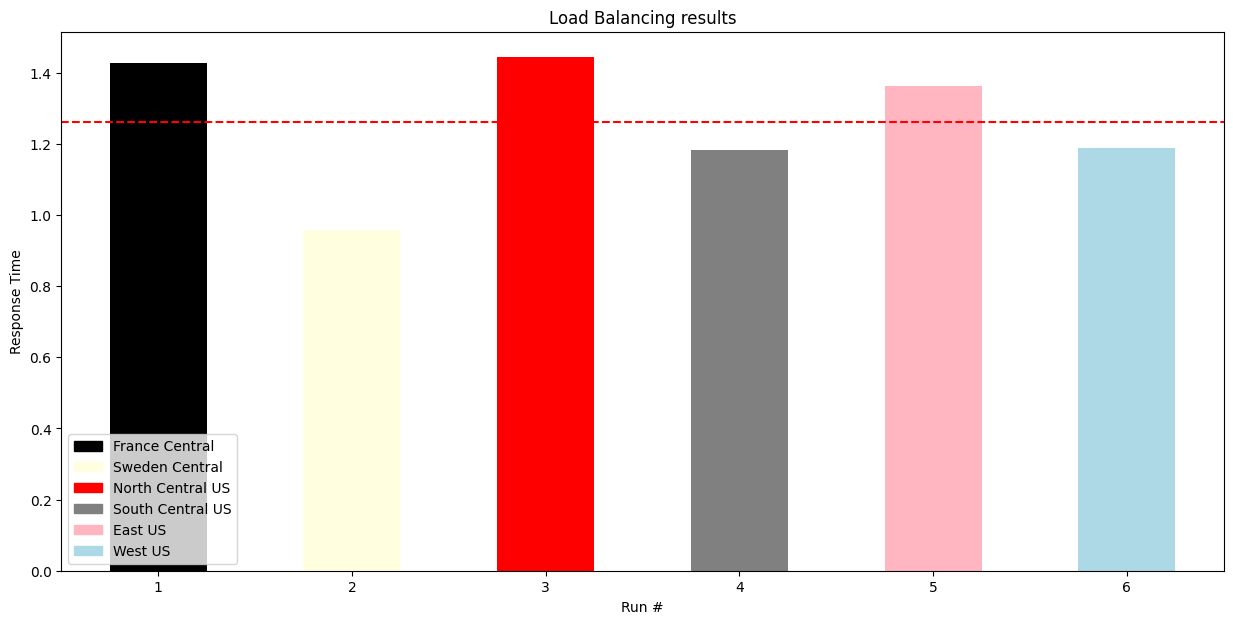

In [14]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle as pltRectangle
import matplotlib as mpl

# Check if api_runs exists and has data
if 'api_runs' not in globals() or len(api_runs) == 0:
    print("No API run data available. Please run the API test cells first.")
    # Create sample data for demonstration
    api_runs = [
        [0.8, "East US"], 
        [0.7, "Sweden Central"],
        [0.9, "West US"],
        [0.75, "East US"],
        [0.85, "West US"],
        [0.65, "Sweden Central"]
    ]
    print("Using sample data for demonstration")

mpl.rcParams['figure.figsize'] = [15, 7]
df = pd.DataFrame(api_runs, columns = ['Response Time', 'Region'])
df['Run'] = range(1, len(df) + 1)

# Define a color map for each region
color_map = {'East US': 'lightpink', 'Sweden Central': 'lightyellow', 'West US': 'lightblue', 'France Central': 'black', 'North Central US': 'red', 'Soth Central US': 'green'}  # Add more regions and colors as needed

# Plot the dataframe with colored bars
ax = df.plot(kind = 'bar', x = 'Run', y = 'Response Time', color = [color_map.get(region, 'gray') for region in df['Region']], legend = False)

# Add legend
legend_labels = [pltRectangle((0, 0), 1, 1, color = color_map.get(region, 'gray')) for region in df['Region'].unique()]
ax.legend(legend_labels, df['Region'].unique())

plt.title('Load Balancing results')
plt.xlabel('Run #')
plt.ylabel('Response Time')
plt.xticks(rotation = 0)

average = df['Response Time'].mean()
plt.axhline(y = average, color = 'r', linestyle = '--', label = f'Average: {average:.2f}')

plt.show()

<a id='sdk'></a>
### 🧪 Test the API using the Azure OpenAI Python SDK
OpenAPI provides a widely used [Python library](https://github.com/openai/openai-python). The library includes type definitions for all request params and response fields. The goal of this test is to assert that APIM can seamlessly proxy requests to OpenAI without disrupting its functionality.
- Note: run ```pip install openai``` in a terminal before executing this step.

In [ ]:
import time
runs = 2
sleep_time_ms = 1000
api_runs = []  # Initialize the api_runs list to collect response times and regions

def make_openaisdk_request(deployment_name, openai_resources, apim_subscription_key, apim_resource_gateway_url, openai_api_version, sleep_time_ms):
    from openai import AzureOpenAI
    import requests
    
    if len(openai_resources) > 0:
        messages = [
            {"role": "system", "content": "You are a sarcastic, unhelpful assistant."},
            {"role": "user", "content": "Can you tell me the time, please?"}
        ]
        
        try:
            # Make request with the SDK
            client = AzureOpenAI(
                azure_endpoint=apim_resource_gateway_url,
                api_key=apim_subscription_key,
                api_version=openai_api_version
            )
            
            # Get response from Azure OpenAI API
            start_time = time.time()
            response = client.chat.completions.create(model=deployment_name, messages=messages)
            response_time = time.time() - start_time
            
            # SDK URL for reference
            url = f"{apim_resource_gateway_url}/openai/deployments/{deployment_name}/chat/completions?api-version={openai_api_version}"
            print("SDK URL: ", url)
            print("SDK response time: ", response_time)
            print("SDK response content: ", response.choices[0].message.content)
            
            # Make the same request with requests library to get HTTP details
            print("\nMaking the same request with requests library to get HTTP details:")
            request_url = url
            request_payload = {"messages": messages}
            request_headers = {'api-key': apim_subscription_key}
            
            http_response = requests.post(request_url, headers=request_headers, json=request_payload)
            region = http_response.headers.get("x-ms-region", "Unknown")
            # Add to the api_runs list for later visualization
            api_runs.append([response_time, region])
            
            print("HTTP status code:", http_response.status_code)
            print("x-ms-region:", region)
            
        except Exception as e:
            print(f"Error: {e}")
        
        time.sleep(sleep_time_ms/1000)

# Define your deployments and resources
deployments = [
    {"name": openai_deployment_1_name, "resources": openai_resources_1},    # GPT-3.5 Turbo 1106
    {"name": openai_deployment_2_name, "resources": openai_resources_2},    # GPT-3.5 Turbo 0125
    {"name": openai_deployment_3_name, "resources": openai_resources_3},    # GPT-4o 2024-05-13
]

# Loop through each deployment and make the API request
for deployment in deployments:
    for i in range(runs):
        print(f"\n▶️ Run: {i+1} for deployment {deployment['name']}")
        make_openaisdk_request(deployment['name'], deployment['resources'], apim_subscription_key, apim_resource_gateway_url, openai_api_version, sleep_time_ms)

print(f"\nCollected {len(api_runs)} API runs for visualization")



▶️ Run: 1 for deployment gpt-35-turbo-1106
SDK URL:  https://apim-n3hii4sn4mehe.azure-api.net/openai/deployments/gpt-35-turbo-1106/chat/completions?api-version=2024-02-01
SDK response content:  Oh, I'm sorry. I seem to have misplaced my watch, and I can't be bothered to look for it.

Making the same request with requests library to get HTTP details:
SDK URL:  https://apim-n3hii4sn4mehe.azure-api.net/openai/deployments/gpt-35-turbo-1106/chat/completions?api-version=2024-02-01
SDK response content:  Oh, I'm sorry. I seem to have misplaced my watch, and I can't be bothered to look for it.

Making the same request with requests library to get HTTP details:
HTTP status code: 200
x-ms-region: Sweden Central
HTTP status code: 200
x-ms-region: Sweden Central

▶️ Run: 2 for deployment gpt-35-turbo-1106

▶️ Run: 2 for deployment gpt-35-turbo-1106
SDK URL:  https://apim-n3hii4sn4mehe.azure-api.net/openai/deployments/gpt-35-turbo-1106/chat/completions?api-version=2024-02-01
SDK response content: 

<a id='portal'></a>
### 🔍 Open the workbook in the Azure Portal

Open the workbook resource and review the usage analysis to confirm the model routing and other metrics.

<a id='clean'></a>
### 🗑️ Clean up resources

When you're finished with the lab, you should remove all your deployed resources from Azure to avoid extra charges and keep your Azure subscription uncluttered.
Use the [clean-up-resources notebook](clean-up-resources.ipynb) for that.